In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.interpolate import interp1d
from scipy.integrate import quad
import scipy.optimize as opt


In [2]:
raw_data = pd.read_csv('3.csv')
raw_data = pd.DataFrame(raw_data).to_numpy()
raw_time = raw_data[:,0] + 10 - 1.41
raw_v = (raw_data[:,1] + .06) / 2


In [3]:
v_interp = interp1d(raw_time, raw_v, kind="linear")

start_time = 0
stop_time = raw_time[-1]
step_size = 0.05
time = np.arange(start_time, stop_time, step_size)

v = v_interp(time)


Our integral is found from 
$$ V_{out} = \int_{0}^{t} \frac{-V_{in}}{RC} \,dt + c $$
where c is out output voltage at t=0  which has already been adjusted for. 
We produced $V_{in}$ with out arbitrary function generator producing a signal modeled by $\frac{sinx}{x}$, with an maximum amplitude of 3.287 V (i.e. a peak voltage of 4 V), and a "frequency" of .64. While we are trying to integrate the sinc function from zero to infinity, this is obviously impossible so we decided that 32 cycles would get us a close-enough estimation. Thus we gave the signal generator a sinc fucntion defined on the range t=0 to the 32nd "cycle," and set the frequency of the signal generator to 20 mHz. This tells us that we will have 32 cycles in 50 seconds, or periodicity of .64 Hz, and a "wavelength" of $2\pi(.64) = 4.02$. 
Note that due to an unfortunate data collection mistake, the input signal recorded by the oscilloscope was not saved. Please see the attatched image to see exactly what the oscillosope saw in one of our trials. (Figure showing integration).

In [71]:
def sinc(t, a, b, c):
    return (a / b) * np.sin(b * t) / t + c

def sinc_int(t, a, b, c):
    return np.array([quad(sinc, 0, ti, args=(a, b, c))[0] for ti in t])

e = [0.01 for i in range(len(v_pred_int))]

def norm_res(predicted, observed, errors):
    return (observed-predicted) / errors


In [5]:
v_pred_int = sinc_int(time, -3.13, 4.02, 0)
v_pred_int[0] = 0

/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_32130/2581356793.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (a / b) * np.sin(b * t) / t + c
/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_32130/2581356793.py:5: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return np.array([quad(sinc, 0, ti, args=(a, b, c))[0] for ti in t])


In [23]:
lin_opt, lin_cov = opt.curve_fit(sinc_int, time[1:], v[1:], p0=[-3.13, 4.02, .1])

a, b, c = lin_opt
da, db, dc = np.sqrt(np.diag(lin_cov))

v_pred_fit = sinc_int(time, a, b, c)
v_pred_fit[0] = 0

/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_32130/2581356793.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (a / b) * np.sin(b * t) / t + c
/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_32130/2581356793.py:5: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  return np.array([quad(sinc, 0, ti, args=(a, b, c))[0] for ti in t])


In the below plot, the Input Function generated by our arbitrary waveform generator (i.e. $V_{in}$) is given wrt time by the function $3.287\frac{\sin(4.02t)}{4.02t}$. Note that the Input Function shown on our graph is theoretically computed and not collected from data as discussed above. Our integrator had a measured RC time constant of 1.05 and thus the integral that our circuit should be computing is: $ \frac{3.287}{1.05} \int_{0}^{50} \frac{\sin(4.02t)}{4.02t} \,dt $ This exact function is plotted plotted below as the Theoretical Output. Note that this function was NOT fitted to our data, and is completely theoretically computed. Finally, the voltage measured by our oscilloscope, or out Integrator Output, is also plotted. Note that in our data processing we have already removed the voltage offset at t=0 (i.e. our integration constant shown in the formula above) so this does not need to be taken into account. Additionally, we had an issue in our data analysis where our voltage measurements were exactly twice that of our theoretical values. Upon reviewing our experimental settup, we realized this was due to the impedance setting out our functon generator, so we went back and divided out voltage readings by 2. 

/var/folders/47/0pv_3t814gx1fytsv44kdscw0000gn/T/ipykernel_32130/1614711703.py:2: RuntimeWarning: invalid value encountered in true_divide
  return (a / b) * np.sin(b * t) / t + c


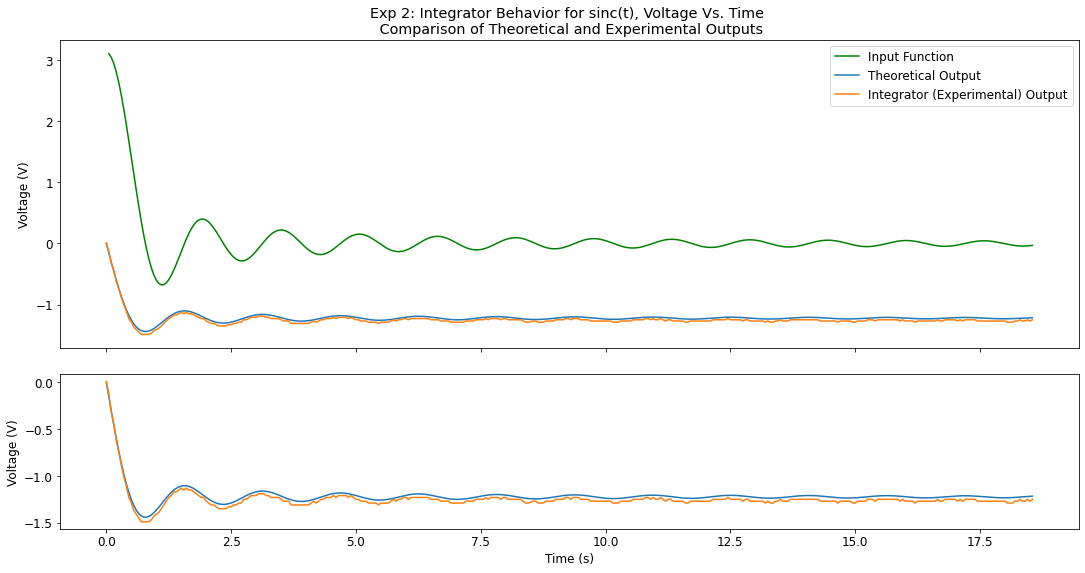

In [72]:
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]}, figsize=(15, 7.5), sharex=True)
f.tight_layout()

ax0.plot(time, sinc(time, 3.13, 4.02, 0), 'green', label=r'Input Function')
ax0.plot(time, v_pred_int, label='Theoretical Output')
ax0.plot(time, v, label='Integrator (Experimental) Output')
ax1.plot(time, v_pred_int)
ax1.plot(time, v)
ax0.legend()
ax0.set_title('Exp 2: Integrator Behavior for sinc(t), Voltage Vs. Time \n Comparison of Theoretical and Experimental Outputs')
ax0.set_ylabel('Voltage (V)')
ax1.set_ylabel('Voltage (V)')
ax1.set_xlabel('Time (s)')

plt.show()

In [ ]:
# plt.plot(time, v_pred_fit, label='Fitted Output')
# plt.axhline(y = (-2.64+.04) / 2)

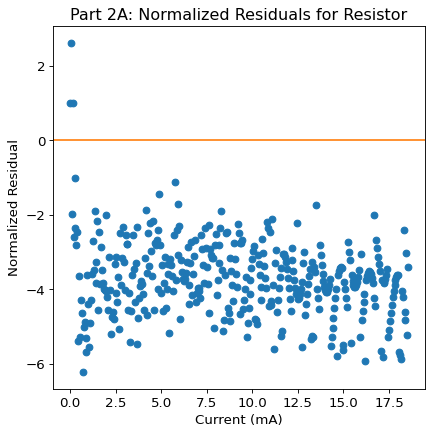

In [32]:
res = norm_res(v_pred_int, v, e)

chi_sq = np.sum(res ** 2)
red_chi_sq = chi_sq / (len(v)-3)

# Plotting residuals time!

fig2=plt.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': '12'})

plt.errorbar(time, res, fmt='o')
plt.axhline(color='tab:orange')

plt.title("Part 2A: Normalized Residuals for Resistor")
plt.xlabel("Current (mA)")
plt.ylabel("Normalized Residual")
plt.show()



In [33]:
red_chi_sq

14.96746005837645

In [28]:
print(da,db,dc)

0.0034441968955927762 0.003226274456256834 8.589733570212409e-05
